# Group 2 Project

## Contributor list

Carson Trimborn $ctrimborn@wisc.edu$

Janice Yu $jyu392@wisc.edu$

Yujun Che $yche25@wisc.edu$

Ziyi Yang $zyan222@wisc.edu$



In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import time
from scipy.stats import uniform

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn import svm, linear_model, datasets, tree
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay
from sklearn.decomposition import PCA

Origional data link: 
Bank Marketing Data
https://data.world/data-society/bank-marketing-data

The Dataset could also be download at:
https://uwmadison.box.com/s/zbt12voi80tk3n7nwwlpfp0y5y3jz4kr

In [2]:
df = pd.read_csv("bank-additional-full.csv",sep=';')
df = df[["age","job","marital","education","housing","loan","campaign","previous","y"]]

# Explore Data Distribution

## Age distribution
    
Most of the clients are between 25 and 55 years old, and the distribution is right skewed. 

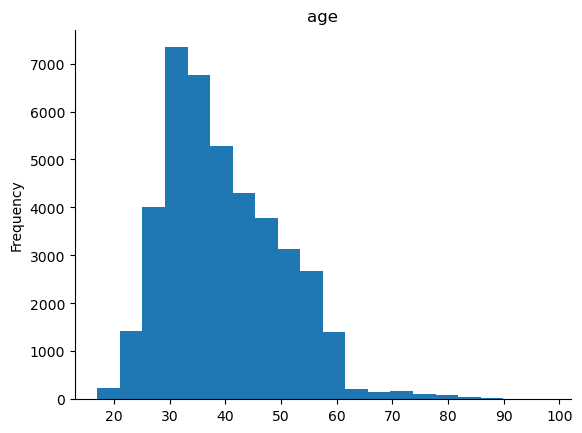

In [3]:
df['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Marital states distribution
    
most of them are married, while the data is kind of balanced that we do not make need further changes. 

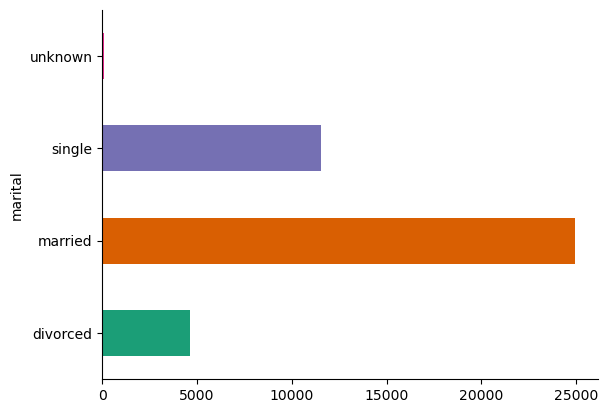

In [4]:
df.groupby('marital').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## Job

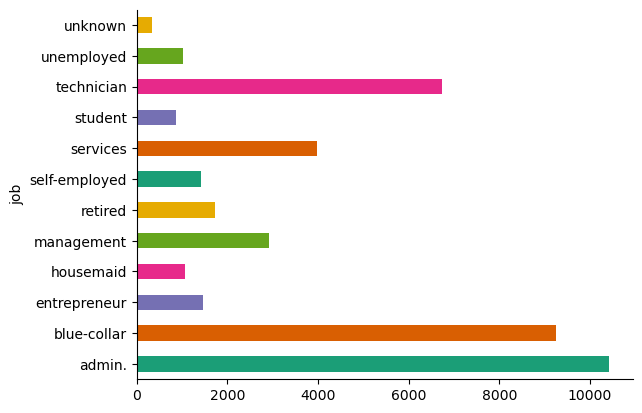

In [5]:
df.groupby('job').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Data Cleaning

In this section, we aims to clean the origional data. 

Every customer is a special case, so it might not be that reasonable to fill NA values by median/predicted values. 

Also, the proportion of NA value is not high in our dataset. Therefore, we decide to drop them.

In [6]:
df.shape

(41188, 9)

In [7]:
#Drop the rows with missing values
df.replace('unknown', pd.NA, inplace=True)
df.dropna(inplace=True)
df.shape

(38245, 9)

The following cells are on coding the dummy variables, binary values, and transfer education level to numerical values. 

In [8]:
# make job as dummy variables
pd.get_dummies(df.job, drop_first=False)
df = df.join(pd.get_dummies(df.job, drop_first=False))

In [9]:
# make marital statues as dummy variables
pd.get_dummies(df.marital, drop_first=False)
df = df.join(pd.get_dummies(df.marital, drop_first=False))

In [10]:
# We encode "education" with ordered number.
# The numerical value represents how many years the clients receive education
education_unique_values = df['education'].unique()
print(education_unique_values)
education_mapping = {
    'illiterate': 0,
    'basic.4y': 4,
    'basic.6y': 6,
    'basic.9y': 9,
    'high.school': 12,
    'professional.course': 14,
    'university.degree': 16
}

df['education'] = df['education'].map(education_mapping)

['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'university.degree' 'illiterate']


In [11]:
# We turn the binary binary data type ("yes"/"no") into 1s and 0s.
binary = df.select_dtypes(include=['object']).columns[df.select_dtypes(include=['object']).nunique() == 2]
df[binary] = df[binary].apply(lambda x: x.map({'yes': 1, 'no': 0}))

In [12]:
# We turn the binary Boolean data type (True/False) into 1s and 0s.
df.replace({True: 1, False: 0}, inplace=True)

In [13]:
df.drop(['job', 'marital'], axis=1, inplace=True)

In [14]:
df.head()

,age,education,housing,loan,campaign,previous,y,admin.,blue-collar,entrepreneur,...,management,retired,self-employed,services,student,technician,unemployed,divorced,married,single
0,56,4,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,57,12,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,37,12,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,40,6,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,56,12,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


# Model building

In this section, we split train and test data and use standard scaler, 

Then, we use algorithm selection to select the best model

In [15]:
X = df.drop('y', axis=1)
y = df['y']

# 80% for training
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y,
test_size=.2, random_state=42, stratify=y)

# of remaining 20%, split in half to get 10% validation, 10% test
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp,
test_size=.5, random_state=42, stratify=y_tmp)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

## vector machine model

In [16]:
# model building
model = SVC(kernel='rbf')
start = time.time()
model.fit(X_train, y_train)
end = time.time()
svm_times = end-start

start = time.time()
# corss validation
scores = cross_val_score(model, X_valid,y_valid, n_jobs = 4)
with np.printoptions(precision=2): 
    print(f'Cross-validation scores={scores}, mean={np.mean(scores):.3}')
end = time.time()
cross_valid_svm = end-start
    
# accuracy    
start = time.time()
y_pred = model.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred)
end = time.time()
test_svm= end-start

print(f'The accuracy of support vector machine is, {svm_accuracy:.3}')
print(f'support vector machine took {svm_times:.3} seconds; its cross_validation step takes {cross_valid_svm :.3} seconds; and prediction time is {test_svm:.3}.')

Cross-validation scores=[0.89 0.89 0.89 0.89 0.89], mean=0.89
The accuracy of support vector machine is, 0.892
support vector machine took 31.5 seconds; its cross_validation step takes 2.41 seconds; and prediction time is 2.84.


Text(0.5, 1.0, 'ROC Curve for SVM')

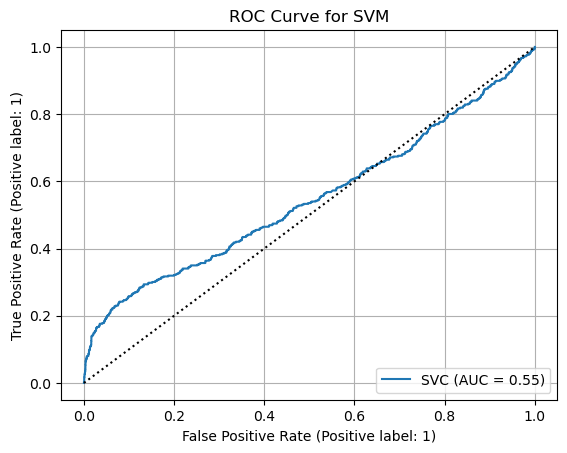

In [17]:
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.plot([0, 1], [0, 1], ':k', label='merely guessing')
plt.grid()
plt.title("ROC Curve for SVM")

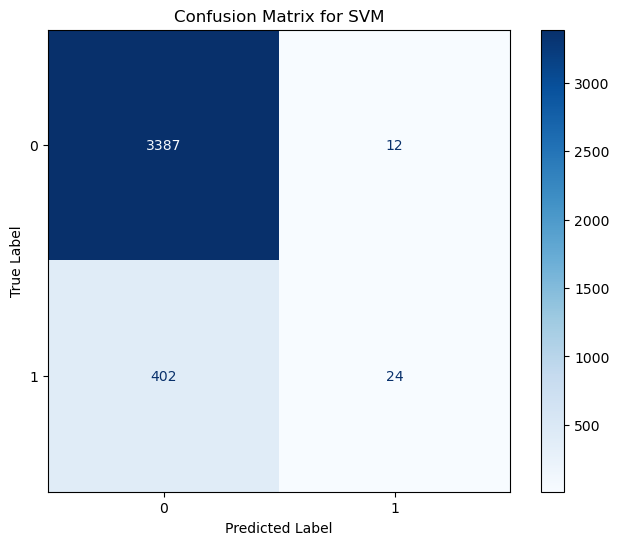

In [18]:
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## PCA analysis

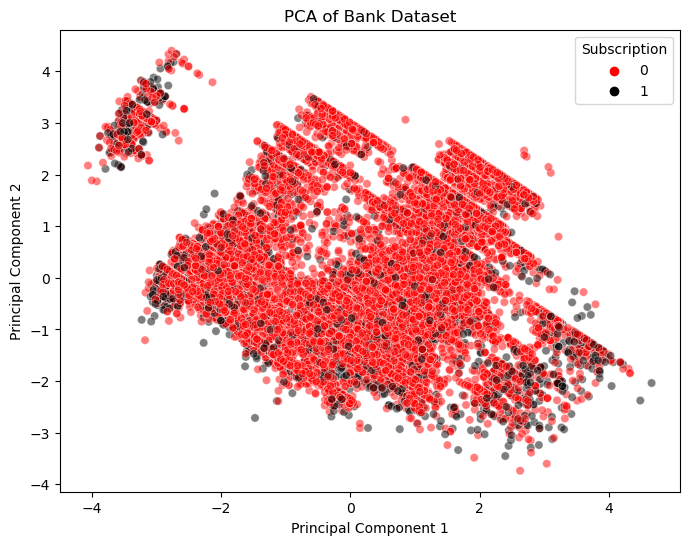

In [19]:
pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_train)

pca_df = pd.DataFrame(data=X_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Subscription'] = y_train.reset_index(drop=True)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='Subscription', data=pca_df,palette=['red', 'black'], alpha=0.5)
plt.title('PCA of Bank Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Subscription')
plt.show()

## Logistic Regression

In [20]:
classifier = linear_model.LogisticRegression(max_iter = 5000)
parameters = {"C": [0.01, 1, 100]}


clf = GridSearchCV(classifier, parameters)
start = time.time()
clf.fit(X_train, y_train)
end = time.time()
logistic_times = end-start
print(f'Logistic Regression took {logistic_times:.3} seconds.')
best_clf = clf.best_estimator_

# corss validation
scores = cross_val_score(clf, X_valid,y_valid)
with np.printoptions(precision=2): 
    print(f'Cross-validation scores={scores}, mean={np.mean(scores):.3}')


# Use the model on test data
start = time.time()
logistic_accuracy = best_clf.score(X_test,y_test)
end = time.time()
test_logistic= end-start

print(f'In the test data, the accuracy is {logistic_accuracy:.3}, and prediction time is {test_logistic:.4}.')

Logistic Regression took 0.261 seconds.
Cross-validation scores=[0.89 0.89 0.89 0.88 0.89], mean=0.89
In the test data, the accuracy is 0.892, and prediction time is 0.0.


Text(0.5, 1.0, 'ROC Curve for Logistic Model')

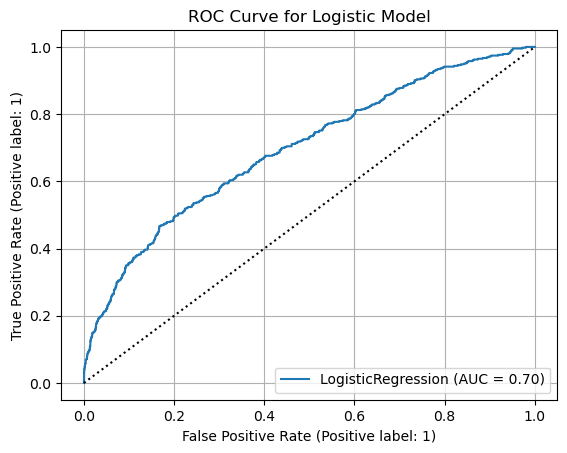

In [21]:
RocCurveDisplay.from_estimator(best_clf, X_test, y_test)
plt.plot([0, 1], [0, 1], ':k', label='merely guessing')
plt.grid()
plt.title("ROC Curve for Logistic Model")

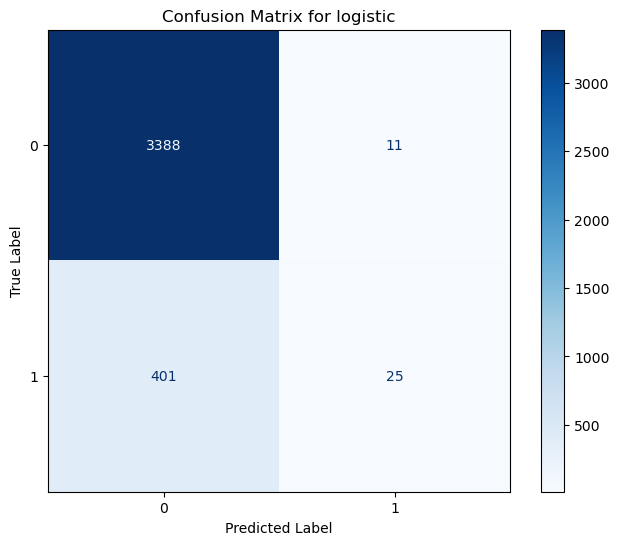

In [22]:
y_hat = best_clf.predict(X_test)
cm = confusion_matrix(y_true=y_test, y_pred=y_hat)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix for logistic')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Decision Tree

Since the result of decision tree will not affect by scaling, we use train-test data without normalization here for better plot.

In [23]:
# use same dataset but without scaling

X_train, X_tmp, y_train, y_tmp = train_test_split(X, y,
test_size=.2, random_state=42, stratify=y)

X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp,
test_size=.5, random_state=42, stratify=y_tmp)

scaler = StandardScaler()


# build model
classifier = DecisionTreeClassifier(criterion='entropy')
parameters = {'max_depth': [1, 3, 5, 7]}
clf = GridSearchCV(classifier, parameters)

start = time.time()
clf.fit(X_train, y_train)
end = time.time()
tree_times = end-start
print(f'Decision Tree took {tree_times:.3} seconds.')
best_clf = clf.best_estimator_

# corss validation
scores = cross_val_score(clf, X_valid,y_valid)
with np.printoptions(precision=2): 
    print(f'Cross-validation scores={scores}, mean={np.mean(scores):.3}')


# test data
start = time.time()
tree_accuracy = best_clf.score(X_test,y_test)
end = time.time()
test_tree= end-start

print(f'In the test data, the accuracy is {tree_accuracy:.3}, and prediction time is {test_tree:.3}.')

Decision Tree took 0.399 seconds.
Cross-validation scores=[0.89 0.89 0.88 0.89 0.89], mean=0.888
In the test data, the accuracy is 0.891, and prediction time is 0.0.


Text(0.5, 1.0, 'ROC Curve for Decision Tree')

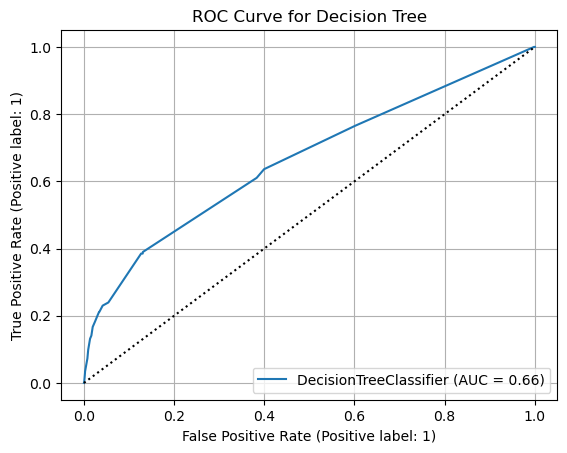

In [24]:
RocCurveDisplay.from_estimator(best_clf, X_test, y_test)
plt.plot([0, 1], [0, 1], ':k', label='merely guessing')
plt.grid()
plt.title("ROC Curve for Decision Tree")

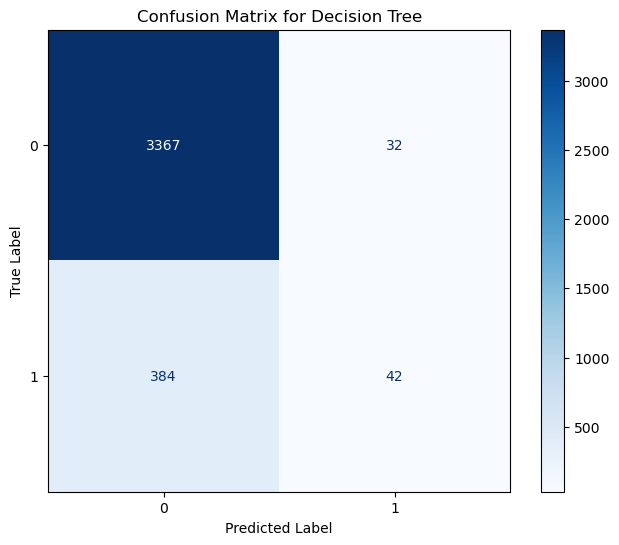

In [25]:
y_hat = best_clf.predict(X_test)
cm = confusion_matrix(y_true=y_test, y_pred=y_hat)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix for Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

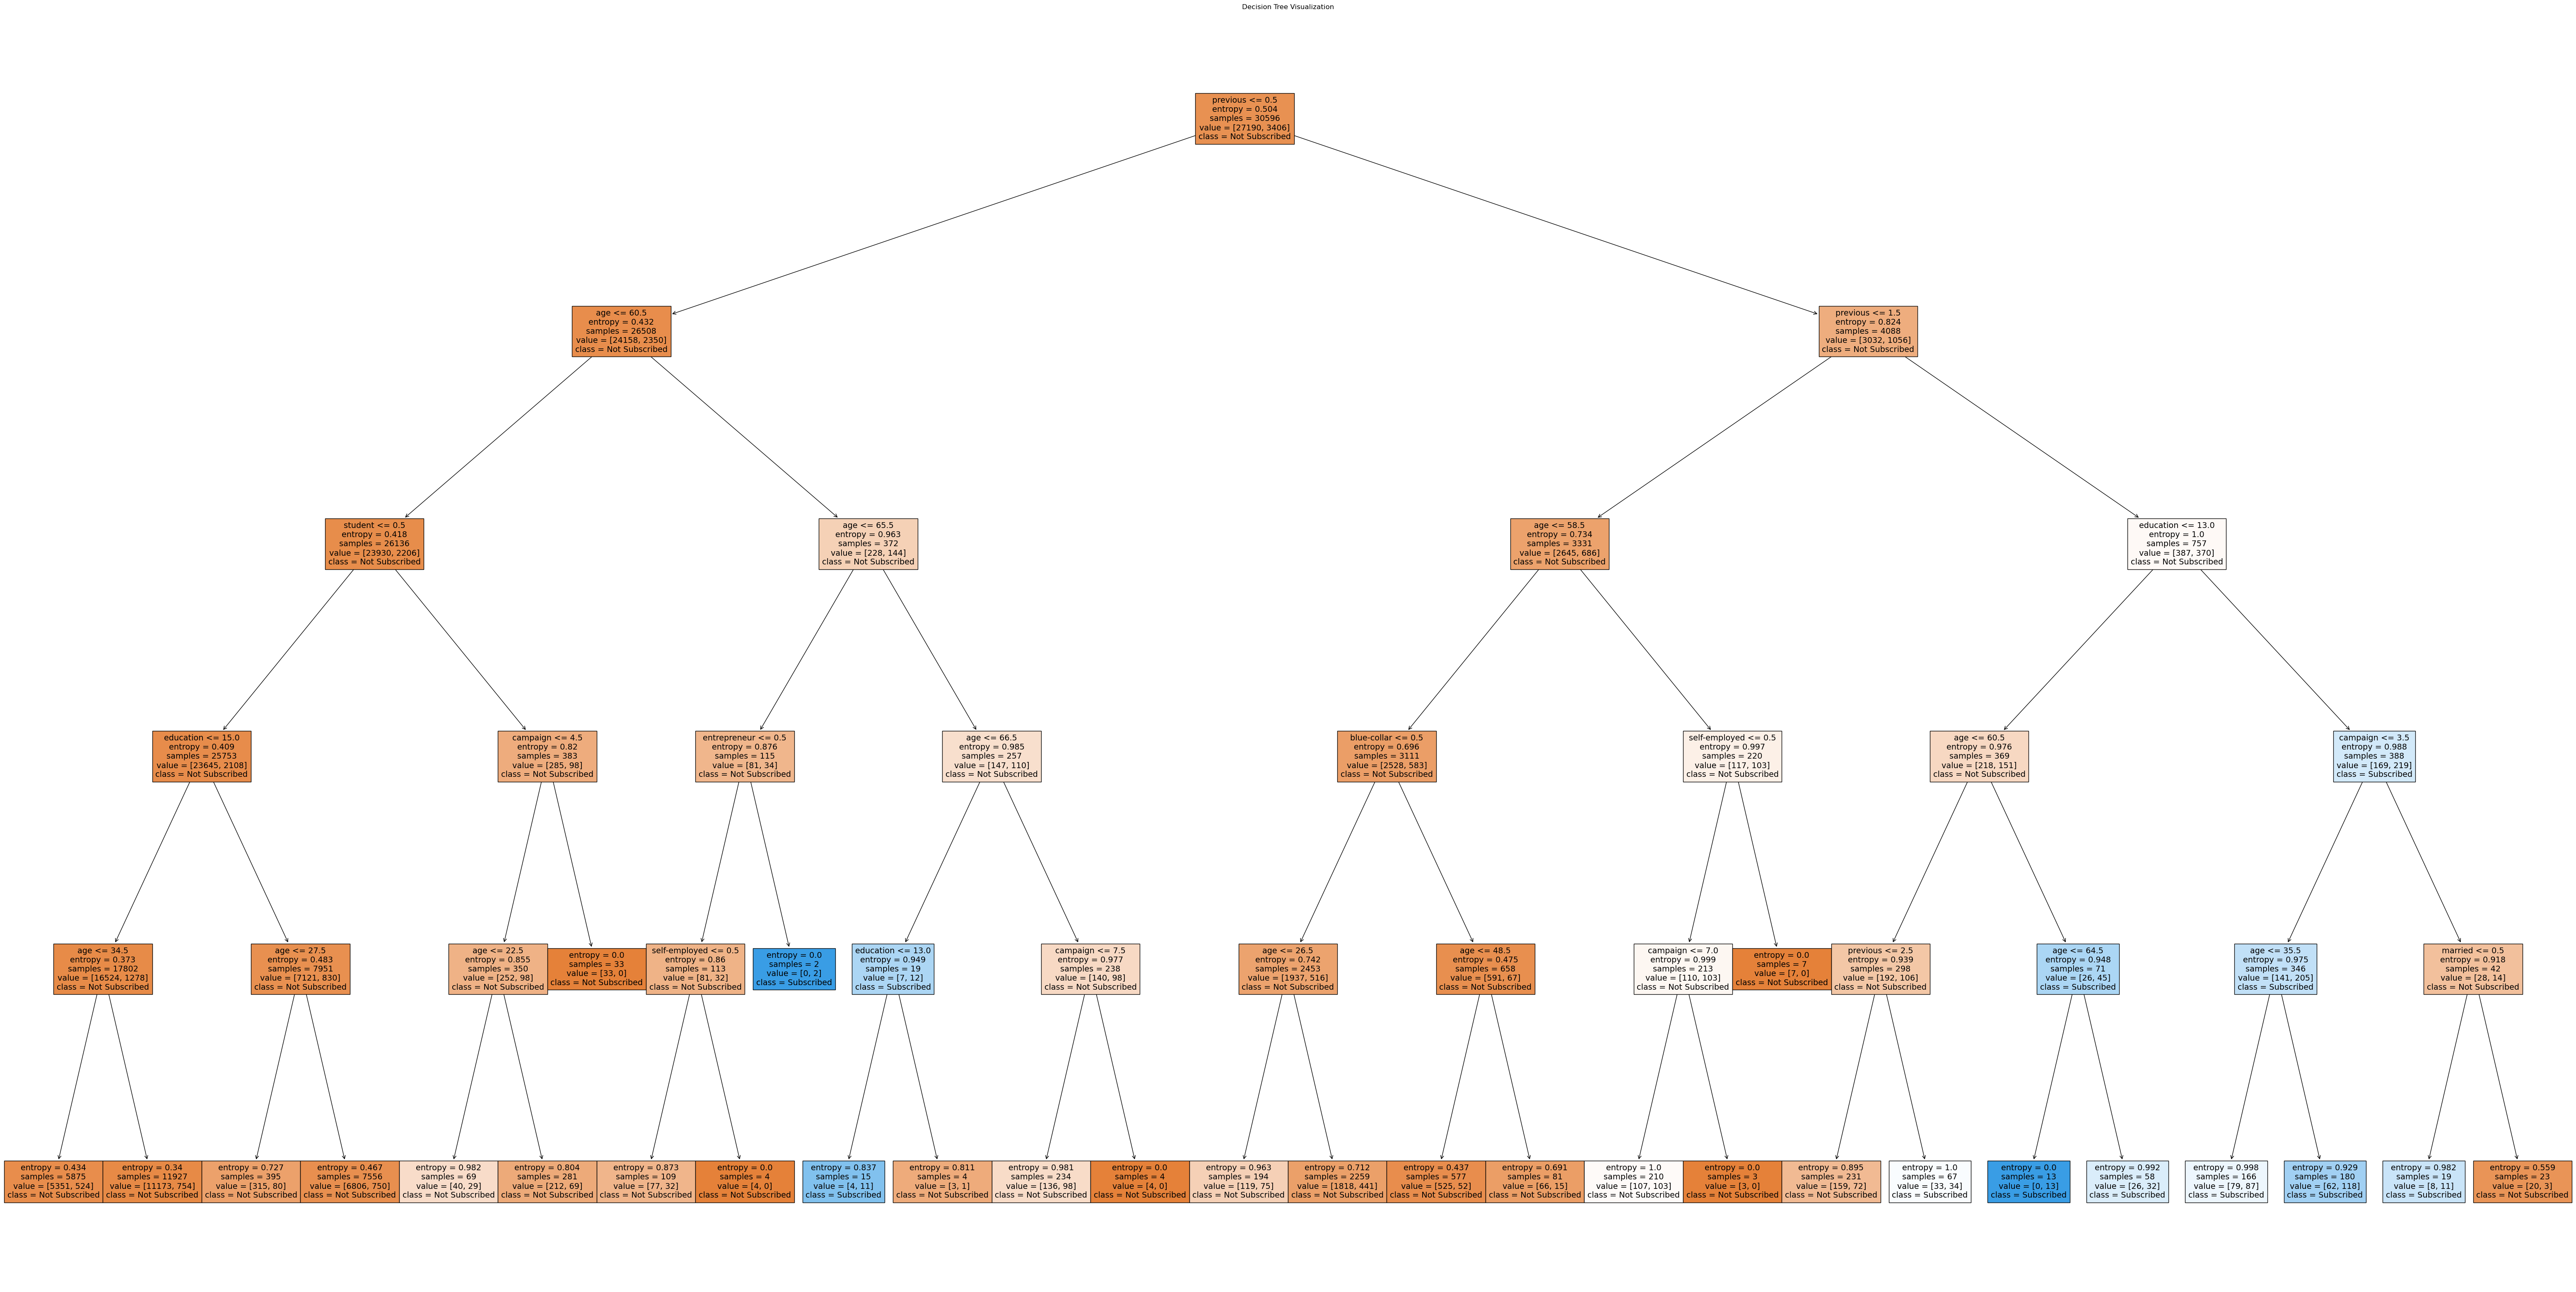

In [26]:
# polt decision tree
plt.figure(figsize=(80, 40))

plot_tree(best_clf, feature_names=X.columns.tolist(), class_names=['Not Subscribed', 'Subscribed'], filled=True)

plt.title('Decision Tree Visualization')

plt.show()

# Final look

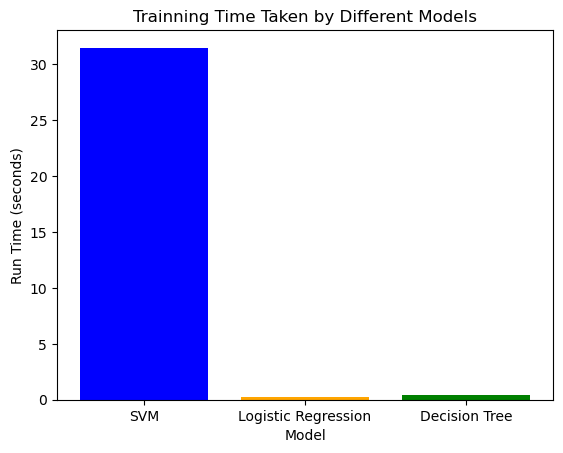

In [27]:
labels = ['SVM', 'Logistic Regression', 'Decision Tree']
values = [svm_times, logistic_times, tree_times]

plt.bar(labels, values, color=['blue', 'orange', 'green'])
plt.xlabel('Model')
plt.ylabel('Run Time (seconds)')
plt.title('Trainning Time Taken by Different Models')

plt.show()

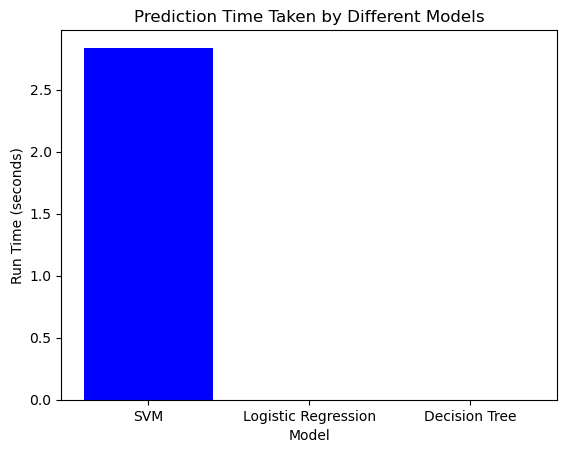

In [28]:
labels = ['SVM', 'Logistic Regression', 'Decision Tree']
values = [test_svm, test_logistic, test_tree]

plt.bar(labels, values, color=['blue', 'orange', 'green'])
plt.xlabel('Model')
plt.ylabel('Run Time (seconds)')
plt.title('Prediction Time Taken by Different Models')

plt.show()

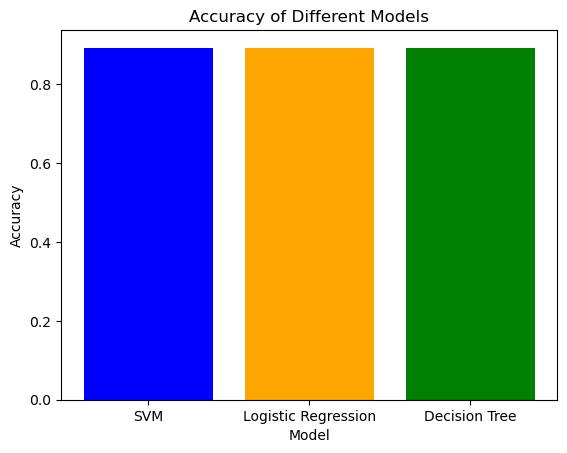

In [29]:
labels = ['SVM', 'Logistic Regression', 'Decision Tree']

values = [svm_accuracy, logistic_accuracy, tree_accuracy]

plt.bar(labels, values, color=['blue', 'orange', 'green'])

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')

plt.show()

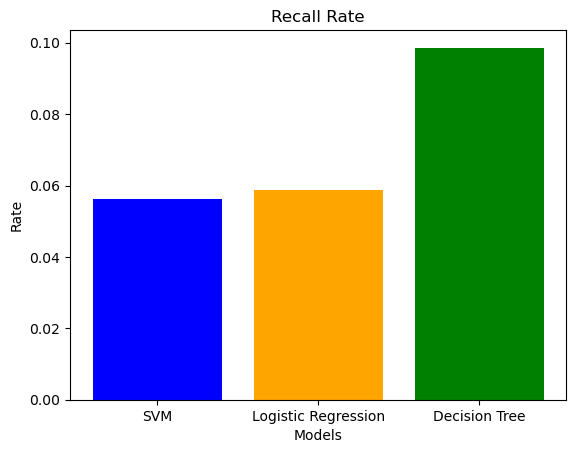

In [30]:
labels = ['SVM', 'Logistic Regression', 'Decision Tree']

values = [24/(402+24), 25/(401+25),42/(384+42)]

plt.bar(labels, values, color=['blue', 'orange', 'green'])

plt.xlabel('Models')
plt.ylabel('Rate')
plt.title('Recall Rate')

plt.show()